# Predicting the future with Facebook Prophet

### Prophet Forecasting Model
Now, let's take a closer look at how Prophet works. In its essence, this library utilizes the [additive regression model](https://en.wikipedia.org/wiki/Additive_model) $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t},$$

where:
* Trend $g(t)$ models non-periodic changes.
* Seasonality $s(t)$ represents periodic changes.
* Holidays component $h(t)$ contributes information about holidays and events.

Prophet is usually compared with:
* `naive` is a simplistic forecasting approach where we predict all future values relying solely on the observation at the last available point of time.
* `snaive` (seasonal naive) is a model that makes constant predictions taking into account information about seasonality. For instance, in the case of weekly seasonal data for each future Monday, we would predict the value from the last Monday, and for all future Tuesdays we would use the value from the last Tuesday and so on.
* `mean` uses the averaged value of data as a forecast.
* `arima` stands for *Autoregressive Integrated Moving Average*, see [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) for details.
* `ets` stands for *Exponential Smoothing*, see [Wikipedia](https://en.wikipedia.org/wiki/Exponential_smoothing) for more.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
#sales_df = pd.read_pickle('data/full_df_tsa1.pkl')
sales_train = pd.read_pickle('data/sales_train_tsa1.pkl')

### Exploratory visual analysis

In [3]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,city,item_category_id,type,subtype
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,Ярославль,37,Кино,Blu
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,Москва,58,Музыка,Винил
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,Москва,58,Музыка,Винил
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,Москва,58,Музыка,Винил
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,Москва,56,Музыка,CD фирменного производства


In [8]:
aggr_df = sales_train.groupby('date')[['item_cnt_day']].sum()
aggr_df.columns = ['item_cnt_day']
daily_df = aggr_df.resample('D').apply(sum)
daily_df.head(n=3)

,item_cnt_day
date,
2013-01-01,1951.0
2013-01-02,8198.0
2013-01-03,7422.0


In [9]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [10]:
plotly_df(daily_df, title='Daily Sales')

High-frequency data can be rather difficult to analyze. Even with the ability to zoom in provided by Plotly, it is hard to infer anything meaningful from this chart apart from the prominent upward and accelerating trend.

To reduce the noise, we will resample the post counts down to weekly bins. Besides binning, other possible techniques of noise reduction include Moving-Average Smoothing and Exponential Smoothing, among others.

In [11]:
weekly_df = daily_df.resample('W').apply(sum)

In [12]:
plotly_df(weekly_df, title='Weekly Sales')

To sum up, from visual analysis we can see that our dataset is non-stationary with a prominent decreasing trend.

## Making a forecast
Prophet's API is very similar to the one you can find in `sklearn`. First we create a model, then call the method `fit`, and, finally, make a forecast. The input to the method `fit` is a `DataFrame` with two columns:
* `ds` (datestamp) must be of type `date` or `datetime`.
* `y` is a numeric value we want to predict.

In [14]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [15]:
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df.tail(n=3)

,ds,y
1031,2015-10-29,1589.0
1032,2015-10-30,2274.0
1033,2015-10-31,3104.0


In [16]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
1001,2015-09-29,4209.0
1002,2015-09-30,4068.0
1003,2015-10-01,2085.0


In [17]:
m = Prophet()
m.fit(train_df);

In [18]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1031,2015-10-29
1032,2015-10-30
1033,2015-10-31


In [19]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1031,2015-10-29,2269.293292,11.049866,2532.552703,2268.174016,2270.768973,-912.768092,-912.768092,-912.768092,-457.867338,-457.867338,-457.867338,-454.900753,-454.900753,-454.900753,0.0,0.0,0.0,1356.525201
1032,2015-10-30,2265.983631,885.342163,3240.175271,2264.778254,2267.550489,-186.318984,-186.318984,-186.318984,214.777855,214.777855,214.777855,-401.096839,-401.096839,-401.096839,0.0,0.0,0.0,2079.664647
1033,2015-10-31,2262.673970,2166.854660,4572.820543,2261.359691,2264.335752,1124.779986,1124.779986,1124.779986,1459.453656,1459.453656,1459.453656,-334.673670,-334.673670,-334.673670,0.0,0.0,0.0,3387.453957


In the resulting dataframe you can see many columns characterizing the prediction, including trend and seasonality components as well as their confidence intervals. The forecast itself is stored in the yhat column.

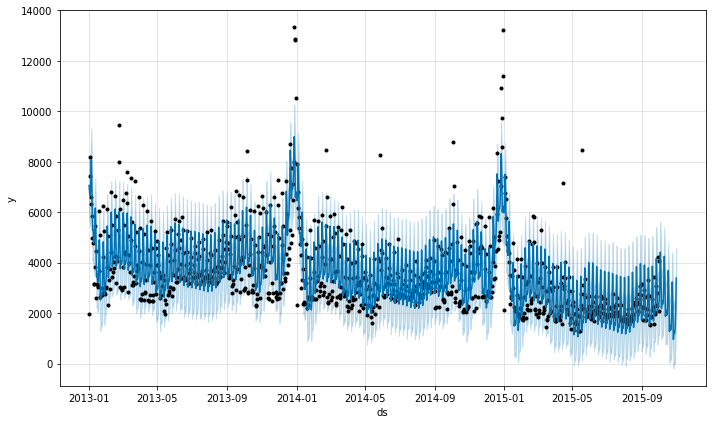

In [20]:
m.plot(forecast);

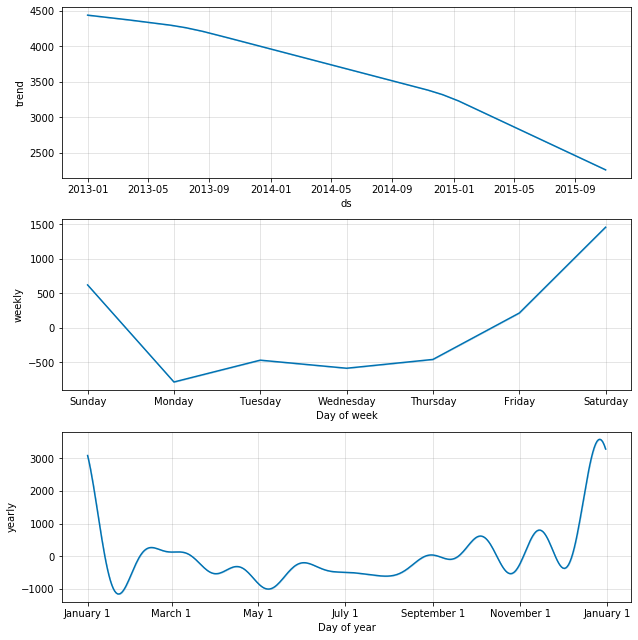

In [21]:
m.plot_components(forecast);

## Forecast quality evaluation

Let's evaluate the quality of the algorithm by calculating the error metrics for the last 30 days that we predicted. For this, we will need the observations $y_i$ and the corresponding predicted values $\hat{y}_i$.

Let's look into the object `forecast` that the library created for us:

In [22]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


We can see that this dataframe contains all the information we need except for the historical values. We need to join the `forecast` object with the actual values `y` from the original dataset `df`. For this we will define a helper function that we will reuse later:

In [23]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [24]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-10-29,1356.525201,11.049866,2532.552703,1589.0
2015-10-30,2079.664647,885.342163,3240.175271,2274.0
2015-10-31,3387.453957,2166.854660,4572.820543,3104.0


We are also going to define a helper function that we will use to gauge the quality of our forecasting with MAPE and MAE error measures:

In [25]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [26]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 24.40481587028595
MAE 484.22508221470076


As a result, the relative error of our forecast (MAPE) is about 24.40%, and on average our model is wrong by 484.225 posts (MAE).

## Visualization

In [39]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Sales'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [40]:
show_forecast(cmp_df, prediction_size, 100, 'Future Sales')

The high value of MAPE that we got above may be explained by the fact that the model failed to catch on to increasing peak-to-peak amplitude of weakly seasonality

## Box-Cox Transformation

So far we have used Prophet with the default settings and the original data. We will leave the parameters of the model alone. But despite this we still have some room for improvement. In this section, we will apply the [Box–Cox transformation](http://onlinestatbook.com/2/transformations/box-cox.html) to our original series. Let's see where it will lead us.

A few words about this transformation. This is a monotonic data transformation that can be used to stabilize variance. We will use the one-parameter Box–Cox transformation, which is defined by the following expression:

$$
\begin{equation}
  boxcox^{(\lambda)}(y_{i}) = \begin{cases}
    \frac{\displaystyle y_{i}^{\lambda} - 1}{\displaystyle \lambda} &, \text{if $\lambda \neq 0$}.\\
    ln(y_{i}) &, \text{if $\lambda = 0$}.
  \end{cases}
\end{equation}
$$

We will need to implement the inverse of this function in order to be able to restore the original data scale. It is easy to see that the inverse is defined as:

$$
\begin{equation}
  invboxcox^{(\lambda)}(y_{i}) = \begin{cases}
    e^{\left (\frac{\displaystyle ln(\lambda y_{i} + 1)}{\displaystyle \lambda} \right )} &, \text{if $\lambda \neq 0$}.\\
    e^{y_{i}} &, \text{if $\lambda = 0$}.
  \end{cases}
\end{equation}
$$

The corresponding function in Python is implemented as follows:

In [32]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [33]:
train_df2 = train_df.copy().set_index('ds')

In [34]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [35]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

In [36]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [37]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 22.72882722861857
MAE 447.63319706527716


In [41]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')

We see that the forecast of weekly changes in the second graph is much closer to the real values now.